# 🧾 Step 1: Setup Notebook

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 🧾 Step 2: Load Data

Format needed:
``` bash
time,open,high,low,close,volume
2023-01-01 00:00,1.0672,1.0679,1.0665,1.0675,123
```

In [2]:
df_raw = pd.read_csv("data/EURUSD_H1.csv", sep='\t', header=0)

# helper maps (preserve original names)
lc_map = {c.lower(): c for c in df_raw.columns}

# build 'time' column from existing fields
if 'time' in lc_map:
    df_raw['time'] = pd.to_datetime(df_raw[lc_map['time']], errors='coerce')
elif '<date>' in lc_map and '<time>' in lc_map:
    df_raw['time'] = pd.to_datetime(df_raw[lc_map['<date>']].astype(str) + ' ' + df_raw[lc_map['<time>']].astype(str),
                                    format='%Y.%m.%d %H:%M:%S', errors='coerce')
elif 'date' in lc_map and 'time' in lc_map:
    df_raw['time'] = pd.to_datetime(df_raw[lc_map['date']].astype(str) + ' ' + df_raw[lc_map['time']].astype(str),
                                    errors='coerce')
else:
    # fallback: try parsing first column as timestamp
    first_col = df_raw.columns[0]
    df_raw['time'] = pd.to_datetime(df_raw[first_col], errors='coerce')

# find volume column
vol_candidates = ['<tickvol>','<vol>','tickvol','vol','volume','<volume>']
vol_col = next((c for c in df_raw.columns if c.lower() in vol_candidates), None)

# map OHLC column names
def find_col(names):
    return next((c for c in df_raw.columns if c.lower() in [n.lower() for n in names]), None)

open_col  = find_col(['<OPEN>','open'])
high_col  = find_col(['<HIGH>','high'])
low_col   = find_col(['<LOW>','low'])
close_col = find_col(['<CLOSE>','close'])

# require OHLC + time
if any(x is None for x in [open_col, high_col, low_col, close_col]):
    raise ValueError(f"Missing OHLC columns. Found: {df_raw.columns.tolist()}")

# rename to standard names
rename_map = {open_col: 'open', high_col: 'high', low_col: 'low', close_col: 'close'}
if vol_col is not None:
    rename_map[vol_col] = 'volume'
df_raw = df_raw.rename(columns=rename_map)

# keep only required columns (if volume missing, fill with NaN)
cols_keep = ['time','open','high','low','close','volume']
for c in cols_keep:
    if c not in df_raw.columns:
        df_raw[c] = np.nan

df = df_raw[cols_keep].copy()
df['time'] = pd.to_datetime(df['time'], errors='coerce')

for c in ['open','high','low','close','volume']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.sort_values('time').drop_duplicates('time').set_index('time')
df = df.dropna(subset=['open','high','low','close'])  # require price data
df.head()

,open,high,low,close,volume
time,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568


# 🧾 Step 3: Feature Engineering

In [3]:
# --- Return Features ---
# Calculate percentage returns over different lookback periods.
# These features capture short-term and medium-term price changes.

df["ret_1"]  = df["close"].pct_change(1)   # 1-period return (momentum)
df["ret_3"]  = df["close"].pct_change(3)   # 3-period return
df["ret_6"]  = df["close"].pct_change(6)   # 6-period return
df["ret_12"] = df["close"].pct_change(12)  # 12-period return
df["ret_24"] = df["close"].pct_change(24)  # 24-period return

# Display the first few rows to inspect new features
df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24
time,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN


In [4]:
# --- True Range and ATR(14) Calculation ---

# True Range (TR) is the maximum of:
# 1. Current high - current low
# 2. Absolute value of current high - previous close
# 3. Absolute value of current low - previous close

hl = df["high"] - df["low"]                          # High-Low range for current period
hc = (df["high"] - df["close"].shift(1)).abs()       # High - Previous Close (absolute)
lc = (df["low"]  - df["close"].shift(1)).abs()       # Low  - Previous Close (absolute)

# Combine all three ranges into a DataFrame and take the row-wise maximum
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)     # True Range for each period

# ATR(14): Average True Range over the past 14 periods
df["atr14"] = tr.rolling(14).mean()                  # 14-period rolling mean of TR

df.head()  # Display the first few rows for inspection

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14
time,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,NaN


In [5]:
# Compute 14-period Relative Strength Index (RSI)
# 1. Calculate price change between consecutive closes
delta = df["close"].diff()

# 2. Separate gains (up moves) and losses (down moves)
gain = delta.clip(lower=0)      # positive changes; negative set to 0
loss = -delta.clip(upper=0)     # negative changes (as positive values); positive set to 0

# 3. Calculate rolling average gain and loss over 14 periods
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

# 4. Compute Relative Strength (RS)
rs = avg_gain / (avg_loss.replace(0, np.nan))  # avoid division by zero

# 5. Convert RS to RSI using the standard formula
df["rsi14"] = 100 - (100 / (1 + rs))

# 6. Fill initial NaN values (from rolling window) with neutral value 50
df["rsi14"] = df["rsi14"].fillna(50)

df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14,rsi14
time,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,NaN,50.0
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,NaN,50.0
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,NaN,50.0
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,NaN,50.0
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,NaN,50.0


In [6]:
# --- MACD (Moving Average Convergence Divergence) Calculation ---
# MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

# 1. Calculate the 12-period Exponential Moving Average (EMA) of the closing price
ema12 = df["close"].ewm(span=12, adjust=False).mean()

# 2. Calculate the 26-period EMA of the closing price
ema26 = df["close"].ewm(span=26, adjust=False).mean()

# 3. MACD line: difference between the 12-period EMA and the 26-period EMA
df["macd"] = ema12 - ema26

# 4. MACD Signal line: 9-period EMA of the MACD line
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

# 5. MACD Histogram: difference between MACD line and Signal line
df["macd_hist"] = df["macd"] - df["macd_signal"]

df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14,rsi14,macd,macd_signal,macd_hist
time,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.000000,0.000000,0.000000e+00
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,NaN,50.0,0.000137,0.000027,1.097664e-04
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,NaN,50.0,0.000097,0.000041,5.577518e-05
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,NaN,50.0,0.000041,0.000041,-5.118825e-07
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,NaN,50.0,0.000122,0.000057,6.469108e-05


In [7]:
# --- Bollinger Bands (20-period, 2 standard deviations) ---
# Bollinger Bands are volatility bands placed above and below a moving average.
# They help identify periods of high or low volatility and potential overbought/oversold conditions.

ma20 = df["close"].rolling(20).mean()         # 20-period simple moving average of close price
std20 = df["close"].rolling(20).std()         # 20-period rolling standard deviation of close price

upper = ma20 + 2 * std20                      # Upper Bollinger Band (MA + 2*STD)
lower = ma20 - 2 * std20                      # Lower Bollinger Band (MA - 2*STD)

# Bollinger %B: position of close price within bands (0=lower, 1=upper)
df["bb_percent"] = (df["close"] - lower) / (upper - lower + 1e-9)

# Bollinger Bandwidth: width of bands relative to MA (volatility measure)
df["bb_bw"] = (upper - lower) / (ma20 + 1e-9)

df.head()  # Display first few rows to inspect new features

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14,rsi14,macd,macd_signal,macd_hist,bb_percent,bb_bw
time,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.000000,0.000000,0.000000e+00,NaN,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,NaN,50.0,0.000137,0.000027,1.097664e-04,NaN,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,NaN,50.0,0.000097,0.000041,5.577518e-05,NaN,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,NaN,50.0,0.000041,0.000041,-5.118825e-07,NaN,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,NaN,50.0,0.000122,0.000057,6.469108e-05,NaN,NaN


In [8]:
# --- Stochastic Oscillator (14, 3) ---
# The Stochastic Oscillator is a momentum indicator comparing a particular closing price to a range of prices over a certain period.
# It consists of two lines:
#   - %K: The current close's position within the recent high-low range (smoothed over 3 periods)
#   - %D: A 3-period moving average of %K

low14  = df["low"].rolling(14).min()                      # Lowest low over the last 14 periods
high14 = df["high"].rolling(14).max()                     # Highest high over the last 14 periods
k = (df["close"] - low14) / (high14 - low14 + 1e-9)       # %K: position of close within range (avoid zero division)
df["stoch_k"] = k.rolling(3).mean()                       # Smoothed %K (3-period moving average)
df["stoch_d"] = df["stoch_k"].rolling(3).mean()           # %D: 3-period moving average of %K

df.head()  # Display first few rows to inspect new features

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14,rsi14,macd,macd_signal,macd_hist,bb_percent,bb_bw,stoch_k,stoch_d
time,,,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,NaN,50.0,0.000137,0.000027,1.097664e-04,NaN,NaN,NaN,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,NaN,50.0,0.000097,0.000041,5.577518e-05,NaN,NaN,NaN,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,NaN,50.0,0.000041,0.000041,-5.118825e-07,NaN,NaN,NaN,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,NaN,50.0,0.000122,0.000057,6.469108e-05,NaN,NaN,NaN,NaN


In [9]:
# --- Candle Structure Features Normalized by ATR ---
# These features describe the shape of each candlestick, normalized by volatility (ATR).
# This helps the model understand price action relative to recent volatility.

eps = 1e-9  # Small constant to avoid division by zero

# Candle body: difference between close and open
body = df["close"] - df["open"]

# Body size normalized by ATR
df["body_atr"] = body / (df["atr14"] + eps)

# Upper wick normalized by ATR:
# Difference between high and the higher of close/open (i.e., top of candle body)
df["uw_atr"] = (df["high"] - df[["close", "open"]].max(axis=1)).clip(lower=0) / (df["atr14"] + eps)

# Lower wick normalized by ATR:
# Difference between the lower of close/open (i.e., bottom of candle body) and low
df["lw_atr"] = (df[["close", "open"]].min(axis=1) - df["low"]).clip(lower=0) / (df["atr14"] + eps)

# Display the first few rows to inspect new features
df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,...,macd,macd_signal,macd_hist,bb_percent,bb_bw,stoch_k,stoch_d,body_atr,uw_atr,lw_atr
time,,,,,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,...,0.000137,0.000027,1.097664e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,...,0.000097,0.000041,5.577518e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,...,0.000041,0.000041,-5.118825e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,...,0.000122,0.000057,6.469108e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# --- Moving Averages and Slope Features ---
# These features help capture short-term and medium-term trend information.

df["ema_10"] = df["close"].ewm(span=10, adjust=False).mean()      # 10-period exponential moving average of close price
df["ema_50"] = df["close"].ewm(span=50, adjust=False).mean()      # 50-period exponential moving average of close price

# Difference between short and long EMA, normalized by current close price
df["ma_diff"] = (df["ema_10"] - df["ema_50"]) / (df["close"] + eps)

# Slope of the 10-period EMA over the last 5 periods (percentage change)
df["ema10_slope5"] = df["ema_10"].pct_change(5)

df.head()  # Display first few rows to inspect new features

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,...,bb_bw,stoch_k,stoch_d,body_atr,uw_atr,lw_atr,ema_10,ema_50,ma_diff,ema10_slope5
time,,,,,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.410690,1.410690,0.000000,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.411003,1.410757,0.000174,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.410926,1.410750,0.000124,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.410808,1.410732,0.000054,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.411000,1.410776,0.000158,NaN


In [11]:
# --- Volatility Features ---
# These features measure recent price volatility, which is important for risk and regime detection.

# 1. Rolling standard deviation of 1-period returns over the last 20 bars (short-term realized volatility)
df["vol_roll20"] = df["ret_1"].rolling(20).std()

# 2. Realized volatility over 30 bars: standard deviation of log returns (captures compounding effects)
df["rv_30"] = np.log(df["close"]).diff().rolling(30).std()

# Display the first few rows to inspect new features
df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,...,stoch_d,body_atr,uw_atr,lw_atr,ema_10,ema_50,ma_diff,ema10_slope5,vol_roll20,rv_30
time,,,,,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.410690,1.410690,0.000000,NaN,NaN,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.411003,1.410757,0.000174,NaN,NaN,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.410926,1.410750,0.000124,NaN,NaN,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.410808,1.410732,0.000054,NaN,NaN,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.411000,1.410776,0.000158,NaN,NaN,NaN


In [12]:
# --- Volume Features ---
# These features help capture volume anomalies and accumulation/distribution patterns.

# 1. Z-score of volume over the last 20 periods (detects volume spikes)
df["vol_z20"] = (df["volume"] - df["volume"].rolling(20).mean()) / (df["volume"].rolling(20).std() + eps)

# 2. On-Balance Volume (OBV): cumulative sum of volume, signed by price change direction
obv = (np.sign(df["close"].diff().fillna(0)) * df["volume"]).fillna(0).cumsum()
df["obv"] = obv

# 3. Z-score of OBV over the last 20 periods (detects OBV anomalies)
df["obv_z20"] = (obv - obv.rolling(20).mean()) / (obv.rolling(20).std() + eps)

# Display the first few rows to inspect new features
df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,...,lw_atr,ema_10,ema_50,ma_diff,ema10_slope5,vol_roll20,rv_30,vol_z20,obv,obv_z20
time,,,,,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,...,NaN,1.410690,1.410690,0.000000,NaN,NaN,NaN,NaN,0.0,NaN
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,...,NaN,1.411003,1.410757,0.000174,NaN,NaN,NaN,NaN,1304.0,NaN
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,...,NaN,1.410926,1.410750,0.000124,NaN,NaN,NaN,NaN,-989.0,NaN
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,...,NaN,1.410808,1.410732,0.000054,NaN,NaN,NaN,NaN,-3102.0,NaN
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,...,NaN,1.411000,1.410776,0.000158,NaN,NaN,NaN,NaN,-534.0,NaN


In [13]:
# --- Time-of-Day and Day-of-Week Cyclical Features ---
# These features encode the hour of day and day of week as cyclical variables,
# allowing the model to capture periodic patterns in market behavior.

df["hour"] = df.index.hour                # Extract hour from timestamp index (0–23)
df["dow"]  = df.index.dayofweek           # Extract day of week from timestamp index (0=Monday, 6=Sunday)

# Encode hour and day-of-week as sine/cosine to preserve cyclical nature
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)   # Sine transformation for hour
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)   # Cosine transformation for hour
df["dow_sin"]  = np.sin(2 * np.pi * df["dow"] / 7)     # Sine transformation for day of week
df["dow_cos"]  = np.cos(2 * np.pi * df["dow"] / 7)     # Cosine transformation for day of week

df.head()  # Display first few rows to inspect new features

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,...,rv_30,vol_z20,obv,obv_z20,hour,dow,hour_sin,hour_cos,dow_sin,dow_cos
time,,,,,,,,,,,,,,,,,,,,,
2009-06-12 00:00:00,1.40954,1.41129,1.40929,1.41069,1002,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0,4,0.000000,1.000000,-0.433884,-0.900969
2009-06-12 01:00:00,1.41072,1.41281,1.41058,1.41241,1304,0.001219,NaN,NaN,NaN,NaN,...,NaN,NaN,1304.0,NaN,1,4,0.258819,0.965926,-0.433884,-0.900969
2009-06-12 02:00:00,1.41243,1.41267,1.40892,1.41058,2293,-0.001296,NaN,NaN,NaN,NaN,...,NaN,NaN,-989.0,NaN,2,4,0.500000,0.866025,-0.433884,-0.900969
2009-06-12 03:00:00,1.41061,1.41177,1.40945,1.41028,2113,-0.000213,-0.000291,NaN,NaN,NaN,...,NaN,NaN,-3102.0,NaN,3,4,0.707107,0.707107,-0.433884,-0.900969
2009-06-12 04:00:00,1.41024,1.41245,1.40968,1.41186,2568,0.001120,-0.000389,NaN,NaN,NaN,...,NaN,NaN,-534.0,NaN,4,4,0.866025,0.500000,-0.433884,-0.900969


In [14]:
# Drop missing values created by rolling windows
df.dropna(inplace=True)
# Show all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(100699, 37)


,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14,rsi14,macd,macd_signal,macd_hist,bb_percent,bb_bw,stoch_k,stoch_d,body_atr,uw_atr,lw_atr,ema_10,ema_50,ma_diff,ema10_slope5,vol_roll20,rv_30,vol_z20,obv,obv_z20,hour,dow,hour_sin,hour_cos,dow_sin,dow_cos
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-06-15 07:00:00,1.39460,1.39486,1.39088,1.39093,3413,-0.002646,-0.004153,-0.004801,-0.008087,-0.011787,0.003016,30.959752,-0.003375,-0.002871,-0.000505,-0.074471,0.009909,0.101451,0.184205,-1.216958,0.086215,0.016580,1.396339,1.403630,-0.005242,-0.002550,0.001568,0.001512,-0.140365,-47341.0,-1.635815,7,0,0.965926,-0.258819,0.0,1.0
2009-06-15 08:00:00,1.39091,1.39136,1.38824,1.38958,4964,-0.000971,-0.004299,-0.005724,-0.009269,-0.012718,0.002903,13.557594,-0.003714,-0.003039,-0.000675,-0.057362,0.011056,0.064414,0.122501,-0.458169,0.155020,0.461614,1.395110,1.403079,-0.005735,-0.002940,0.001559,0.001480,0.516931,-52305.0,-2.154043,8,0,0.866025,-0.500000,0.0,1.0
2009-06-15 09:00:00,1.38959,1.39010,1.38626,1.38718,5497,-0.001727,-0.005335,-0.006418,-0.009808,-0.016352,0.002974,13.032827,-0.004129,-0.003257,-0.000871,-0.081901,0.012553,0.046642,0.070836,-0.810278,0.171470,0.309318,1.393669,1.402456,-0.006335,-0.003648,0.001580,0.001490,0.721180,-57802.0,-2.487722,9,0,0.707107,-0.707107,0.0,1.0
2009-06-15 10:00:00,1.38715,1.38900,1.38650,1.38785,4731,0.000483,-0.002214,-0.006358,-0.008516,-0.013211,0.003022,14.540202,-0.004353,-0.003476,-0.000877,0.037152,0.013806,0.077757,0.062938,0.231624,0.380525,0.215079,1.392611,1.401883,-0.006681,-0.003991,0.001540,0.001501,0.451102,-53071.0,-1.659751,10,0,0.500000,-0.866025,0.0,1.0
2009-06-15 11:00:00,1.38785,1.38832,1.38513,1.38726,4939,-0.000425,-0.001670,-0.005962,-0.010182,-0.012935,0.002983,15.329949,-0.004526,-0.003686,-0.000840,0.072475,0.015075,0.090831,0.071743,-0.197797,0.157567,0.714080,1.391638,1.401310,-0.006972,-0.004224,0.001507,0.001468,0.678930,-58010.0,-1.923145,11,0,0.258819,-0.965926,0.0,1.0


# 🧾 Step 4: Create Target (Up/Down)

We’ll predict next bar direction:

- 1 if next close is higher (BUY)

- 0 if next close is lower (SELL)

In [15]:
# Create binary target: 1 if next close is higher than current close, else 0
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

# Optionally filter out samples where the next move is too small compared to ATR (likely noise)
move_abs = (df["close"].shift(-1) - df["close"]).abs()      # Absolute next-bar move
noise_thr = 0.03 * df["atr14"]                              # Noise threshold: 3% of ATR (adjustable)
df = df[move_abs > noise_thr].dropna()                      # Keep only significant moves, drop missing values

df.head()  # Show first few rows for inspection

,open,high,low,close,volume,ret_1,ret_3,ret_6,ret_12,ret_24,atr14,rsi14,macd,macd_signal,macd_hist,bb_percent,bb_bw,stoch_k,stoch_d,body_atr,uw_atr,lw_atr,ema_10,ema_50,ma_diff,ema10_slope5,vol_roll20,rv_30,vol_z20,obv,obv_z20,hour,dow,hour_sin,hour_cos,dow_sin,dow_cos,target
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-06-15 07:00:00,1.39460,1.39486,1.39088,1.39093,3413,-0.002646,-0.004153,-0.004801,-0.008087,-0.011787,0.003016,30.959752,-0.003375,-0.002871,-0.000505,-0.074471,0.009909,0.101451,0.184205,-1.216958,0.086215,0.016580,1.396339,1.403630,-0.005242,-0.002550,0.001568,0.001512,-0.140365,-47341.0,-1.635815,7,0,0.965926,-0.258819,0.0,1.0,0
2009-06-15 08:00:00,1.39091,1.39136,1.38824,1.38958,4964,-0.000971,-0.004299,-0.005724,-0.009269,-0.012718,0.002903,13.557594,-0.003714,-0.003039,-0.000675,-0.057362,0.011056,0.064414,0.122501,-0.458169,0.155020,0.461614,1.395110,1.403079,-0.005735,-0.002940,0.001559,0.001480,0.516931,-52305.0,-2.154043,8,0,0.866025,-0.500000,0.0,1.0,0
2009-06-15 09:00:00,1.38959,1.39010,1.38626,1.38718,5497,-0.001727,-0.005335,-0.006418,-0.009808,-0.016352,0.002974,13.032827,-0.004129,-0.003257,-0.000871,-0.081901,0.012553,0.046642,0.070836,-0.810278,0.171470,0.309318,1.393669,1.402456,-0.006335,-0.003648,0.001580,0.001490,0.721180,-57802.0,-2.487722,9,0,0.707107,-0.707107,0.0,1.0,1
2009-06-15 10:00:00,1.38715,1.38900,1.38650,1.38785,4731,0.000483,-0.002214,-0.006358,-0.008516,-0.013211,0.003022,14.540202,-0.004353,-0.003476,-0.000877,0.037152,0.013806,0.077757,0.062938,0.231624,0.380525,0.215079,1.392611,1.401883,-0.006681,-0.003991,0.001540,0.001501,0.451102,-53071.0,-1.659751,10,0,0.500000,-0.866025,0.0,1.0,0
2009-06-15 11:00:00,1.38785,1.38832,1.38513,1.38726,4939,-0.000425,-0.001670,-0.005962,-0.010182,-0.012935,0.002983,15.329949,-0.004526,-0.003686,-0.000840,0.072475,0.015075,0.090831,0.071743,-0.197797,0.157567,0.714080,1.391638,1.401310,-0.006972,-0.004224,0.001507,0.001468,0.678930,-58010.0,-1.923145,11,0,0.258819,-0.965926,0.0,1.0,0


# 🧾 Step 5: Split Data

In [ ]:
# --- Feature Selection and Train/Test/Validation Split ---

# List of feature column names to use for modeling
features = [
    # returns/trend
    "ret_1","ret_3","ret_6","ret_12","ret_24","ma_diff","ema10_slope5",
    # volatility
    "atr14","vol_roll20","rv_30","bb_bw",
    # momentum/oscillators
    "rsi14","macd","macd_signal","macd_hist","bb_percent","stoch_k","stoch_d",
    # candle structure
    "body_atr","uw_atr","lw_atr",
    # volume
    "vol_z20","obv_z20",
    # time-of-day and day-of-week
    "hour_sin","hour_cos","dow_sin","dow_cos"
]

# Feature matrix and target vector
X = df[features]
y = df["target"]

# Split data into train/validation/test sets (chronologically)
n = len(df)
test_n = int(0.2 * n)           # 20% for test
val_n  = int(0.1 * (n - test_n))# 10% of remaining for validation

# Train/test split
X_train_full, X_test = X.iloc[: n - test_n], X.iloc[n - test_n :]
y_train_full, y_test = y.iloc[: n - test_n], y.iloc[n - test_n :]

# Train/validation split from training set
X_train, X_val = X_train_full.iloc[: -val_n], X_train_full.iloc[-val_n: ]
y_train, y_val = y_train_full.iloc[: -val_n], y_train_full.iloc[-val_n: ]

# 🧾 Step 6: Train XGBoost Model

In [17]:
# --- Train XGBoost Model with Early Stopping and Fallback Adapter ---
# This block trains an XGBoost binary classifier with early stopping on a validation set.
# It handles compatibility between the sklearn wrapper and native xgboost.train API.

# Compute class imbalance weight for XGBoost (helps with imbalanced target)
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos = float(neg) / max(1.0, float(pos))

from xgboost import XGBClassifier
# Instantiate sklearn wrapper for XGBoost (hyperparameters set for tabular data)
model = XGBClassifier(
    n_estimators=3000,         # Maximum number of boosting rounds
    learning_rate=0.03,        # Step size shrinkage
    max_depth=5,               # Maximum tree depth
    subsample=0.8,             # Row subsample ratio
    colsample_bytree=0.8,      # Feature subsample ratio
    min_child_weight=3,        # Minimum sum of instance weight needed in a child
    reg_lambda=1.0,            # L2 regularization
    reg_alpha=0.0,             # L1 regularization
    gamma=0.0,                 # Minimum loss reduction for split
    scale_pos_weight=scale_pos,# Class imbalance weight
    tree_method="hist",        # Fast histogram-based algorithm
    eval_metric="logloss",     # Evaluation metric
    random_state=42,           # Reproducibility
)

# Early stopping callback (stops training if no improvement for N rounds)
from xgboost import callback as xgb_callback
early_stop = xgb_callback.EarlyStopping(rounds=150, save_best=True)

import xgboost as xgb

try:
    # Try fitting using sklearn wrapper (recent XGBoost versions support callbacks)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],      # Validation set for early stopping
        callbacks=[early_stop],         # Early stopping callback
        verbose=False,                  # Suppress training output
    )
except TypeError:
    # Fallback: Use native xgboost.train API if wrapper does not accept callbacks
    params = {
        "objective": "binary:logistic",
        "eta": 0.03,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 3,
        "lambda": 1.0,
        "alpha": 0.0,
        "gamma": 0.0,
        "scale_pos_weight": scale_pos,
        "eval_metric": "logloss",
        "tree_method": "hist",
        "seed": 42,
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    evallist = [(dtrain, "train"), (dval, "validation")]

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=3000,
        evals=evallist,
        early_stopping_rounds=150,
        verbose_eval=False,
    )

    # Adapter class to provide predict_proba and get_booster methods for compatibility
    class XGBAdapter:
        # Adapter for xgboost Booster to mimic sklearn API.
        # Provides predict_proba, predict, and get_booster methods.
        def __init__(self, booster, feature_names):
            self.booster = booster
            self.feature_names = feature_names

        def predict_proba(self, X):
            dm = xgb.DMatrix(X, feature_names=self.feature_names)
            ntree = getattr(self.booster, "best_ntree_limit", None)
            if ntree is None:
                ntree = getattr(self.booster, "best_iteration", None)

            # Try legacy kwarg, then newer kwarg, then bare predict.
            try:
                if ntree is not None:
                    raw = self.booster.predict(dm, ntree_limit=ntree)
                else:
                    raw = self.booster.predict(dm)
            except TypeError:
                try:
                    if ntree is not None:
                        raw = self.booster.predict(dm, iteration_range=(0, int(ntree)))
                    else:
                        raw = self.booster.predict(dm)
                except Exception:
                    raw = self.booster.predict(dm)

            return self._format_proba(raw)

        def _format_proba(self, raw):
            p = np.asarray(raw)
            # If model already returns two-column probs, pass through.
            if p.ndim == 2 and p.shape[1] == 2:
                return p
            # otherwise assume single-column probability for positive class
            return np.vstack([1 - p, p]).T

        def predict(self, X):
            return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

        def get_booster(self):
            return self.booster

    model = XGBAdapter(booster, X_train.columns.tolist())

# Robustly get best iteration / number of trees used for best model
best_trees = getattr(model, "best_iteration", None)
if best_trees is None:
    booster = model.get_booster()
    best_trees = getattr(booster, "best_iteration", getattr(booster, "best_ntree_limit", None))
print("Best trees:", best_trees)

Best trees: 40


# 🧾 Step 7: Evaluate Model

In [18]:
# Threshold tuning on validation
proba_val = model.predict_proba(X_val)[:,1]
grid = np.linspace(0.3, 0.7, 41)
best_t, best_f1 = 0.5, -1
for t in grid:
    f1 = f1_score(y_val, (proba_val >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t
print(f"Best threshold (F1): {best_t:.3f} (F1={best_f1:.3f})")

# Lock in threshold and evaluate on test
proba_test = model.predict_proba(X_test)[:,1]
pred_test = (proba_test >= best_t).astype(int)
print("Accuracy:", accuracy_score(y_test, pred_test))
print("AUC:", roc_auc_score(y_test, proba_test))
print("F1:", f1_score(y_test, pred_test))
print("MCC:", matthews_corrcoef(y_test, pred_test))

Best threshold (F1): 0.300 (F1=0.657)
Accuracy: 0.5010494280617064
AUC: 0.5230712858400562
F1: 0.6675988394448911
MCC: 0.0


# 🧾 Step 8: Save Model

In [19]:
os.makedirs("models", exist_ok=True)
joblib.dump({"model": model, "threshold": float(best_t), "features": features}, "models/forex_model.pkl")

['models/forex_model.pkl']

# 🧾 Step 9: Backtest inside Jupyter

In [20]:
# Use the trained model
y_proba = proba_test                            # from tuning cell
y_pred = (y_proba >= best_t).astype(int)        # tuned threshold

# Copy test set
bt = df.iloc[-len(X_test):].copy()
bt["probability"] = proba_test
bt["prediction"] = (bt["probability"] >= best_t).astype(int)

# Simulated strategy: if model says up -> take close, else short
bt["strategy_return"] = bt["prediction"].shift(1) * bt["ret_1"]

# Cumulative equity curves
bt["market_cum"]   = (1 + bt["ret_1"]).cumprod()
bt["strategy_cum"] = (1 + bt["strategy_return"]).cumprod()

# 🧾 Step 10: Plot Equity Curves vs Price

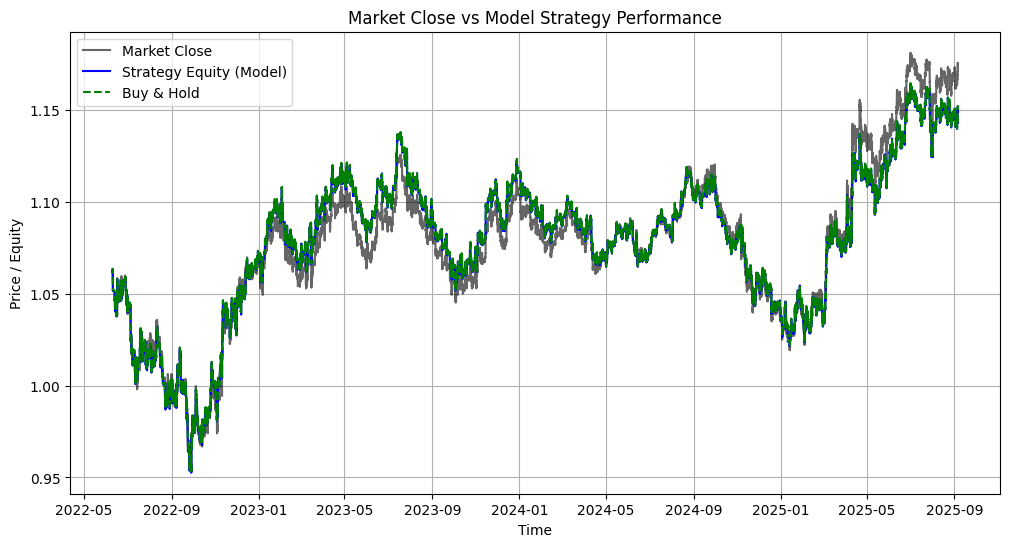

In [21]:
plt.figure(figsize=(12,6))

# Market price (closing)
plt.plot(bt.index, bt["close"], label="Market Close", color="black", alpha=0.6)

# Strategy equity curve
plt.plot(bt.index, bt["strategy_cum"] * bt["close"].iloc[0], 
         label="Strategy Equity (Model)", color="blue")

# Market buy & hold equity
plt.plot(bt.index, bt["market_cum"] * bt["close"].iloc[0], 
         label="Buy & Hold", color="green", linestyle="--")

plt.legend()
plt.title("Market Close vs Model Strategy Performance")
plt.xlabel("Time")
plt.ylabel("Price / Equity")
plt.grid(True)
plt.show()


# 🧾 Step 11: Plot Signals on Chart

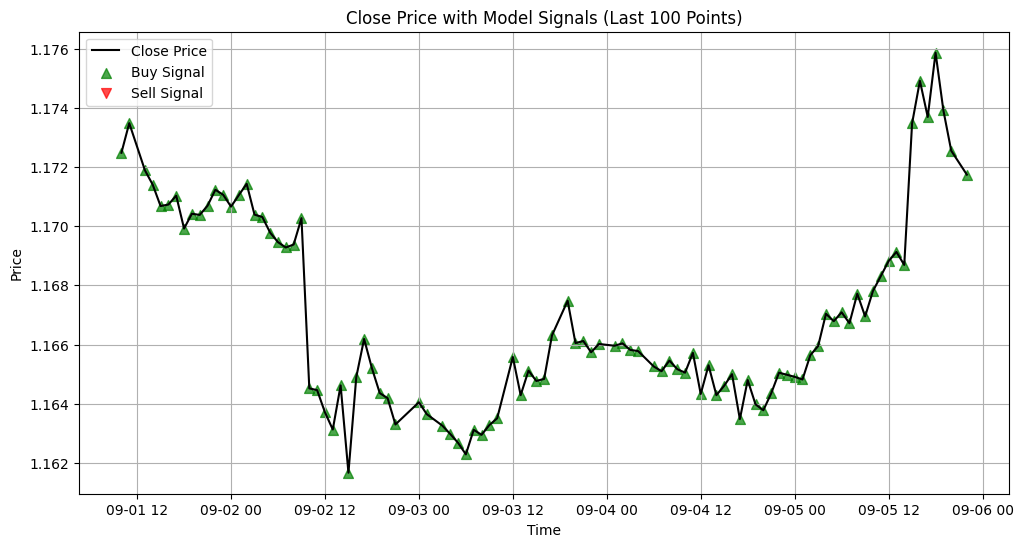

In [22]:
# Focus on the last 200 points for clarity
bt_focus = bt.tail(100)

plt.figure(figsize=(12,6))
plt.plot(bt_focus.index, bt_focus["close"], label="Close Price", color="black")

# Plot buy signals
plt.scatter(bt_focus.index[bt_focus["prediction"]==1], 
            bt_focus["close"][bt_focus["prediction"]==1],
            marker="^", color="green", alpha=0.7, label="Buy Signal", s=50)

# Plot sell signals
plt.scatter(bt_focus.index[bt_focus["prediction"]==0], 
            bt_focus["close"][bt_focus["prediction"]==0],
            marker="v", color="red", alpha=0.7, label="Sell Signal", s=50)

plt.legend()
plt.title(f"Close Price with Model Signals (Last {bt_focus.shape[0]} Points)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()